# Variational Gaussian Process (分類、白色化あり)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

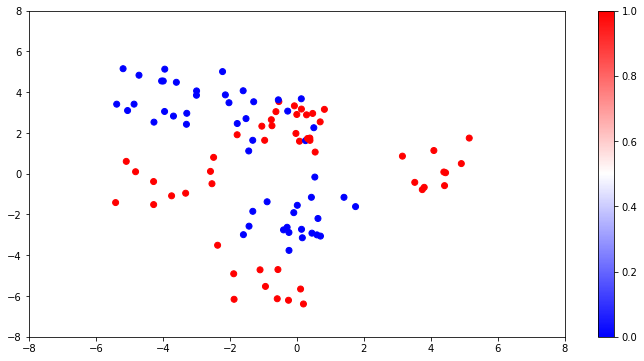

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
estimator = VGP(X, y, kernel, likelihood, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_steps = 1000
for step in range(n_steps):
    loss = svi.step()
    if step % (n_steps / 10) == 0:
        print(loss)

85.93979920849426
72.14831354699243
67.49498561198888
60.324896803560534
63.38411555684152
49.096073263326105
65.16068608274679
58.68024030283206
63.91998792258161
61.99995334829171


---

## 推論結果

### 予測分布

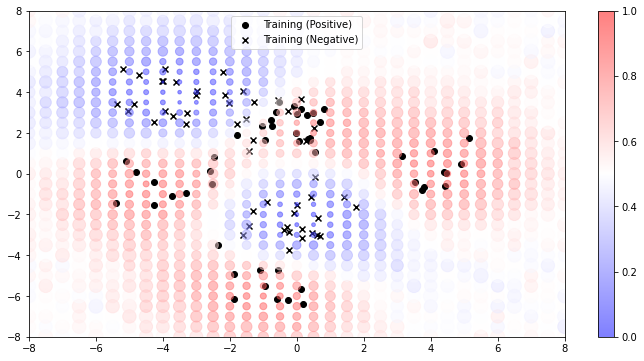

CPU times: user 656 ms, sys: 30.7 ms, total: 687 ms
Wall time: 491 ms


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    s = ((pnew_std - pnew_std[:, 0].min()) / pnew_std[:, 0].std() + 0.1) * 50
    plt.figure(figsize = (12, 6))
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = Xnew[:, 0], y = Xnew[:, 1], c = pnew_mean[:, 0], s = s, marker = "o", cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.colorbar()
    plt.legend()
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.7122, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.f_loc

Parameter containing:
tensor([[ 3.3198e-01, -1.8681e+00,  1.4916e+00,  2.6385e-01,  7.6977e-01,
         -2.8172e-02,  7.5156e-01, -2.4080e+00,  1.2123e+00, -3.1203e-01,
         -7.3997e-01, -1.2053e+00,  5.0708e-01, -9.8573e-01,  6.3286e-01,
          2.4581e-01,  1.0226e+00, -1.0681e+00,  3.7892e-01, -7.9353e-02,
          4.0516e-01, -1.8755e-01, -7.4945e-03, -5.2612e-02,  5.4880e-01,
         -1.6674e-02,  5.2748e-01, -9.5000e-01, -7.2656e-02, -4.0561e-02,
         -1.8965e-01,  7.9115e-03,  2.1662e-01,  1.2129e-01, -6.7306e-02,
         -2.3674e-01, -4.1223e-02,  9.1960e-02, -5.0165e-02, -9.3138e-02,
          3.9250e-02, -1.1766e-01,  4.2855e-02,  1.6484e-01, -9.5899e-02,
          3.7637e-02,  1.8736e-01, -5.0319e-02, -3.1694e-02, -1.4696e-01,
          2.4252e-02,  1.6700e-02,  2.2739e-02,  1.4312e-01,  9.8812e-02,
         -4.1792e-02, -7.0022e-02, -1.0462e-01, -1.2176e-01,  2.5007e-02,
         -6.3505e-02, -4.1028e-02, -6.4610e-02,  1.4382e-02,  1.9042e-01,
         -1.6762

In [12]:
estimator.f_cov

tensor([[[ 0.1861,  0.0152,  0.0213,  ...,  0.0464,  0.0610,  0.0088],
         [ 0.0152,  0.5591, -0.0268,  ...,  0.0033,  0.0644,  0.0110],
         [ 0.0213, -0.0268,  0.6475,  ..., -0.1163, -0.0056, -0.0230],
         ...,
         [ 0.0464,  0.0033, -0.1163,  ...,  1.7104, -0.0314, -0.1488],
         [ 0.0610,  0.0644, -0.0056,  ..., -0.0314,  1.8050,  0.1242],
         [ 0.0088,  0.0110, -0.0230,  ..., -0.1488,  0.1242,  1.6151]]],
       grad_fn=<UnsafeViewBackward>)